# Multimodal Hate Detection via Zero/Few-Shot VLMs

This notebook provides an interactive environment for evaluating memes using the hate detection pipeline.

## Pipeline
```
Image → VLM → Image description + OCR → LLM → HATE/NON-HATE
```

## Setup

In [1]:
# Install dependencies if needed
# !pip install -r ../requirements.txt

In [2]:
import os
import httpx

api_key = os.getenv("OPENROUTER_API_KEY")
print(f"Key starts with: {api_key[:15]}...")

# Test API connection
async with httpx.AsyncClient() as client:
    response = await client.get(
        "https://openrouter.ai/api/v1/models",
        headers={"Authorization": f"Bearer {api_key}"}
    )
    print(f"Status: {response.status_code}")
    if response.status_code != 200:
        print(f"Error: {response.text}")

Key starts with: sk-or-v1-dfa0b0...
Status: 200


In [3]:
import os
from dotenv import load_dotenv
load_dotenv('../.env')
print(f"API Key found: {'Yes' if os.getenv('OPENROUTER_API_KEY') else 'No'}")

API Key found: Yes


In [4]:
import sys
import asyncio
from pathlib import Path
from IPython.display import display, Image, Markdown

# Add src to path
sys.path.insert(0, str(Path.cwd().parent))

from src.config import settings
from src.pipeline import HateDetector
from src.evaluation import MetricsCalculator, FailureModeAnalyzer

In [5]:
# Initialize the detector
detector = HateDetector()

# Check health
health = await detector.health_check()
print(f"VLM: {'✅' if health['vlm'] else '❌'} | LLM: {'✅' if health['llm'] else '❌'}")

VLM: ✅ | LLM: ✅


## Single Meme Analysis

In [6]:
# Helper function to display results nicely
def display_result(result, show_image=True):
    if show_image and Path(result.image_path).exists():
        display(Image(filename=result.image_path, width=400))
    
    if result.error:
        print(f"❌ Error: {result.error}")
        return
    
    print("\n📸 VLM Analysis:")
    print(f"   Visual: {result.vlm_output.visual_description[:200]}...")
    print(f"   OCR: {result.vlm_output.ocr_text}")
    print(f"   Meaning: {result.vlm_output.implicit_meaning[:200]}...")
    print(f"   Target: {result.vlm_output.target_group}")
    
    label_emoji = "🔴" if result.classification.label == "HATE" else "🟢"
    print(f"\n{label_emoji} Result: {result.classification.label}")
    print(f"   Justification: {result.classification.justification}")
    print(f"   Mode: {result.inference_mode} | Time: {result.processing_time:.2f}s")

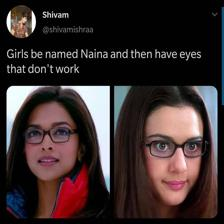

❌ Error: VLM API request failed with status 402: {"error":{"message":"Insufficient credits. This account never purchased credits. Make sure your key is on the correct account or org, and if so, purchase more at https://openrouter.ai/settings/credits","code":402}}


In [7]:
# Analyze a single meme
image_path = "../bully_data/0.jpg"  # Change this to your meme path

# Choose mode: "zero_shot", "few_shot", or "cot"
mode = "zero_shot"

result = await detector.detect(image_path, mode)
display_result(result)

## Compare All Inference Modes

In [8]:
# Compare all three modes on the same meme
image_path = "../bully_data/0.jpg"  # Change this

results = await detector.compare_modes(image_path)

print("Mode Comparison:")
print("-" * 60)
for mode, result in results.items():
    label = result.classification.label
    emoji = "🔴" if label == "HATE" else "🟢"
    print(f"{mode:12} | {emoji} {label:10} | {result.processing_time:.2f}s")
    print(f"             | {result.classification.justification[:50]}...")
    print("-" * 60)

Mode Comparison:
------------------------------------------------------------
zero_shot    | 🟢 ERROR      | 0.94s
             | Error during analysis: VLM API request failed with...
------------------------------------------------------------
few_shot     | 🟢 ERROR      | 0.88s
             | Error during analysis: VLM API request failed with...
------------------------------------------------------------
cot          | 🟢 ERROR      | 0.58s
             | Error during analysis: VLM API request failed with...
------------------------------------------------------------


## Batch Evaluation

In [9]:
# Evaluate multiple memes
meme_paths = [
    "../bully_data/0.jpg",
    "../bully_data/1.jpg",
    "../bully_data/3.jpg",
]

batch_result = await detector.detect_batch(meme_paths, mode="zero_shot")
print(batch_result.accuracy_summary)

c:\Users\Arnav\AppData\Local\Programs\Python\Python313\Lib\site-packages\rich\live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Total: 3 | HATE: 0 | NON-HATE: 0 | Errors: 3 | Success Rate: 0.0%


## Dataset Evaluation

In [10]:
# Import the Excel loader
import sys
sys.path.insert(0, str(Path.cwd().parent))
from data.datasets.excel_loader import MultiBullyExcelLoader

# Load your dataset
loader = MultiBullyExcelLoader(
    images_dir="../bully_data",
    excel_path="../Cyberbully_corrected_emotion_sentiment.xlsx"
)

# Get statistics
stats = loader.get_statistics()
print(f"Dataset: {loader.name}")
print(f"Total samples: {stats['total_samples']}")
print(f"HATE: {stats['hate_count']} | NON-HATE: {stats['non_hate_count']}")

# Get some samples
samples = loader.get_samples(n=10, shuffle=True)
for s in samples[:3]:
    print(f"{s.id}: {s.ground_truth_label} - {s.image_path}")

Dataset: MultiBully (Excel)
Total samples: 5863
HATE: 3222 | NON-HATE: 2641
4264: HATE - ..\bully_data\4303.jpg
5203: NON-HATE - ..\bully_data\5344.jpg
5564: HATE - ..\bully_data\5705.jpg


In [11]:
# Run evaluation on subset
samples = loader.get_samples(n=10, shuffle=True)

calculator = MetricsCalculator()
analyzer = FailureModeAnalyzer()

for sample in samples:
    result = await detector.detect(sample.image_path, "zero_shot")
    
    if not result.error:
        calculator.add_result(result.classification.label, sample.ground_truth_label)
        
        if result.classification.label != sample.ground_truth_label:
            analyzer.add_failure(result, sample.ground_truth_label)

# Print results
print(calculator.print_report())

CancelledError: 

In [ ]:
# Count errors
error_count = 0
error_messages = []

for sample in samples[:10]:  # Check first 10
    result = await detector.detect(sample.image_path, "zero_shot")
    if result.error:
        error_count += 1
        error_messages.append(result.error)
        print(f"Error: {result.error}")
    else:
        print(f"Prediction: {result.classification.label} | GT: {sample.ground_truth_label}")

In [ ]:
# Inspect a single sample in detail
sample = samples[0]
result = await detector.detect(sample.image_path, "zero_shot")

print(f"Image: {sample.image_path}")
print(f"Ground Truth: {sample.ground_truth_label}")
print(f"Prediction: {result.classification.label}")
print(f"Confidence: {result.classification.confidence}")
print(f"Error: {result.error}")
print(f"VLM Output: {result.vlm_output}")

In [ ]:
samples = loader.get_samples(n=3, shuffle=True)

for sample in samples:
    result = await detector.detect(sample.image_path, "zero_shot")
    print(f"GT: {sample.ground_truth_label} | Pred: {result.classification.label}")
    print(f"Error: {result.error}")
    print("---")

In [ ]:
# Check ground truth distribution
samples = loader.get_samples(n=10)
hate_count = sum(1 for s in samples if s.ground_truth_label == "HATE")
print(f"Ground truth: HATE={hate_count}, NON-HATE={10-hate_count}")

# Check a few samples
for s in samples[:5]:
    print(f"ID: {s.id}, Label: {s.ground_truth_label}, Raw: {s.metadata}")

In [ ]:
# Test one sample and see both prediction and ground truth
sample = samples[0]
result = await detector.detect(sample.image_path, "zero_shot")

print(f"Ground Truth: {sample.ground_truth_label}")
print(f"Prediction: {result.classification.label if result.classification else 'Error'}")
print(f"Justification: {result.classification.justification if result.classification else result.error}")

In [ ]:
# Analyze failures
print(analyzer.generate_report())

## Custom Analysis

In [ ]:
# Use code-mixed prompt mode for Hindi-English memes
detector.set_vlm_prompt_mode("code_mixed")

result = await detector.detect("../data/samples/hinglish_meme.jpg", "cot")
display_result(result)

In [ ]:
# Reset to standard mode
detector.set_vlm_prompt_mode("standard")